In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy.stats import shapiro, normaltest
import hdbscan
import umap.umap_ as umap
from itertools import product
from hdbscan.validity import validity_index
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df=pd.read_csv(r"")
print(df.shape)
print(df.dtypes)
print(df.head())

(200, 5)
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [3]:
#loại bỏ cột ID
if 'CustomerID' in df.columns:
    df.drop(columns=['CustomerID'], inplace=True)
    print("Đã loại bỏ cột CustomerID.")

print("\nCác cột còn lại sau khi loại bỏ:")
print(df.columns.tolist())

Đã loại bỏ cột CustomerID.

Các cột còn lại sau khi loại bỏ:
['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [4]:
#kiểm tra missing value
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
#loại bỏ dòng trùng
df.duplicated().sum()
df.drop_duplicates(inplace=True)

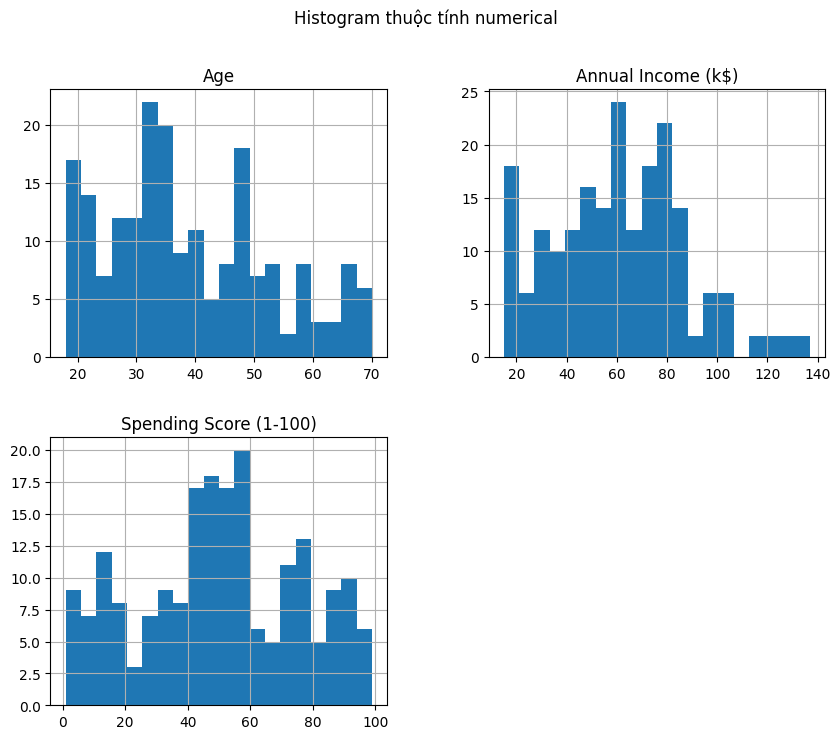

In [6]:
#histogram biến
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols].hist(bins=20, figsize=(10, 8))
plt.suptitle("Histogram thuộc tính numerical")
plt.show()


In [7]:
# phân phối của biến phân loại
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())



Value counts for Gender:
Female    112
Male       88
Name: Gender, dtype: int64


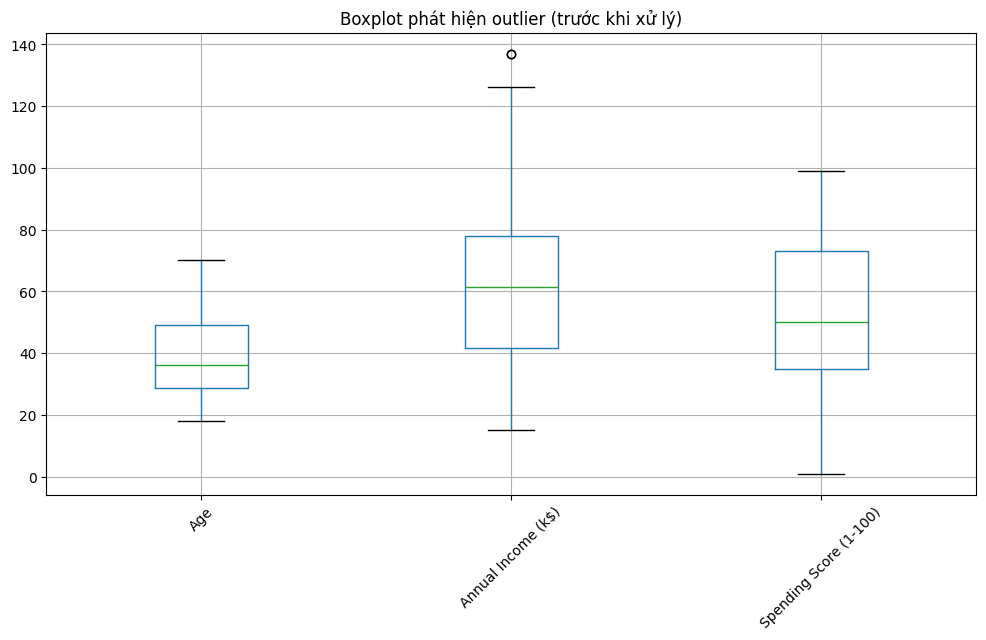

In [8]:
#kiểm tra outlier
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Boxplot phát hiện outlier (trước khi xử lý)")
plt.xticks(rotation=45)
plt.show()


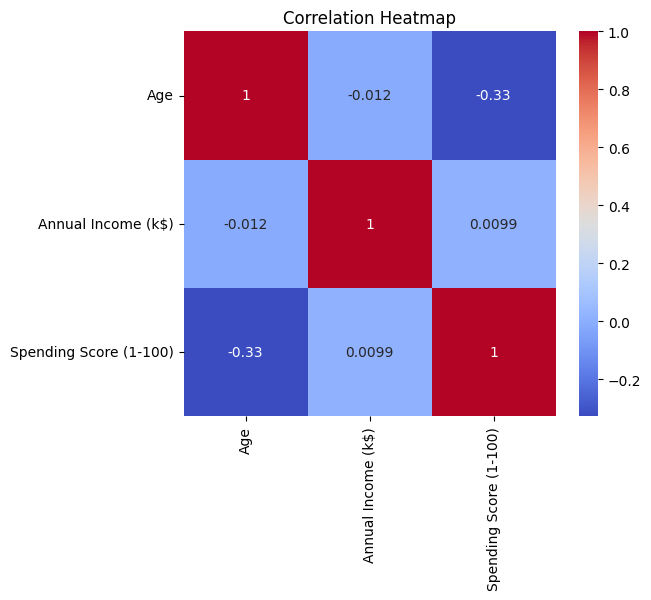

In [9]:
#ma trận tương quan
corr = df[numeric_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Sau khi loại outlier: (198, 4)


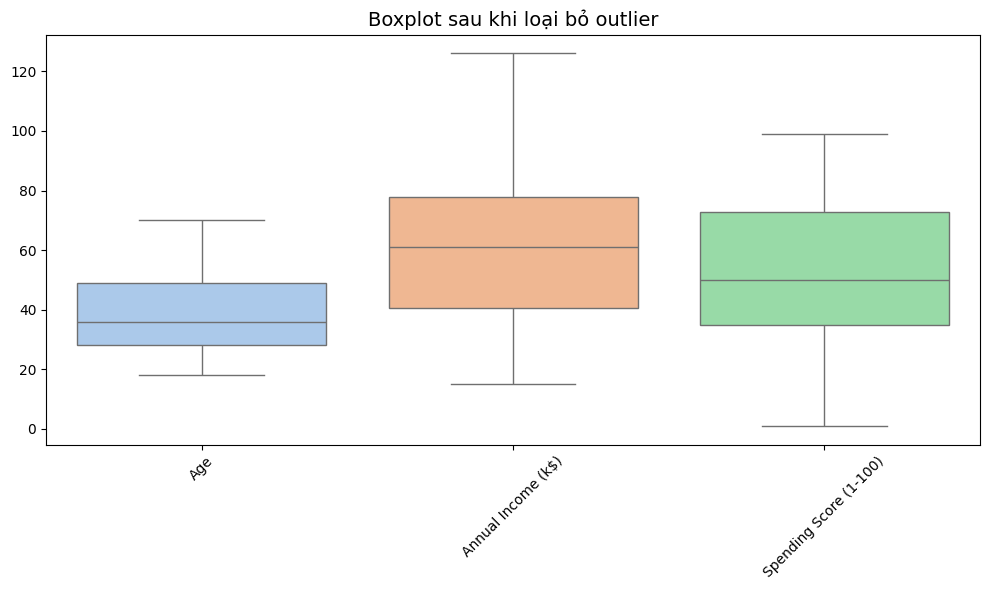

In [10]:
#xử lí outlier
def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

numeric_cols = df.select_dtypes(include=np.number).columns
df = remove_outliers_iqr(df, numeric_cols)
print("Sau khi loại outlier:", df.shape)

# boxplot sau khi loại bỏ outlier
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_cols], palette="pastel")
plt.title("Boxplot sau khi loại bỏ outlier", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

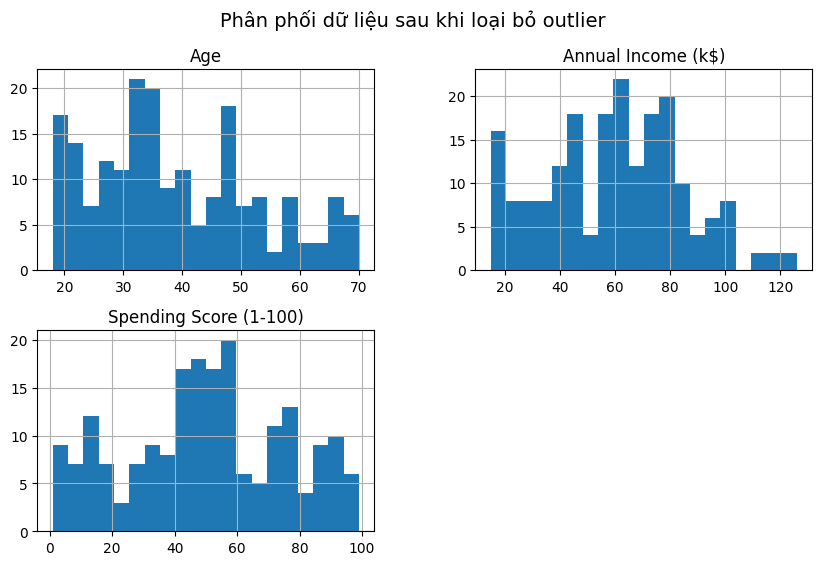

In [11]:
#phân phối sau khi loại bỏ outlier
#histogram
df.hist(bins=20, figsize=(10,6))
plt.suptitle("Phân phối dữ liệu sau khi loại bỏ outlier", fontsize=14)
plt.show()

In [12]:
#mã hóa biến phân loại
df = pd.get_dummies(df, drop_first=True, dtype=int)
print("Sau khi mã hóa:", df.shape)
print(df.head())

Sau khi mã hóa: (198, 4)
   Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0   19                  15                      39            1
1   21                  15                      81            1
2   20                  16                       6            0
3   23                  16                      77            0
4   31                  17                      40            0



Kết quả kiểm định phân phối chuẩn:


,Feature,Shapiro_p,DAgostino_p,Kết luận
0,Age,0.000004,0.000373,Không chuẩn
1,Annual Income (k$),0.008206,0.220469,Không chuẩn
2,Spending Score (1-100),0.000291,0.000684,Không chuẩn


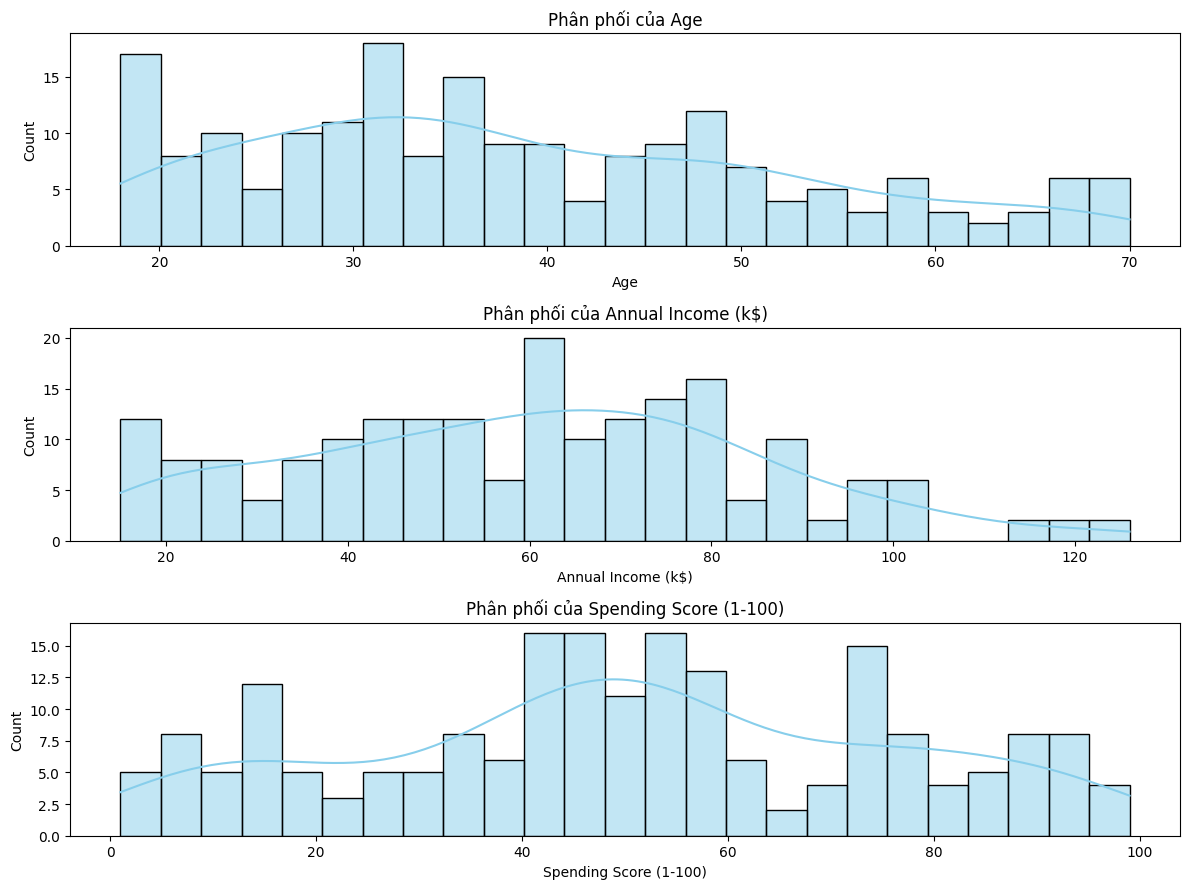


Thống kê mô tả dữ liệu:


,count,mean,std,min,25%,50%,75%,max
Age,198.0,38.929293,14.016852,18.0,28.25,36.0,49.00,70.0
Annual Income (k$),198.0,59.787879,25.237259,15.0,40.50,61.0,77.75,126.0
Spending Score (1-100),198.0,50.196970,25.746846,1.0,35.00,50.0,72.75,99.0



Các cột không chuẩn: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Đã áp dụng PowerTransformer (Yeo–Johnson) cho các cột không chuẩn.
Đã chuẩn hóa toàn bộ dữ liệu.


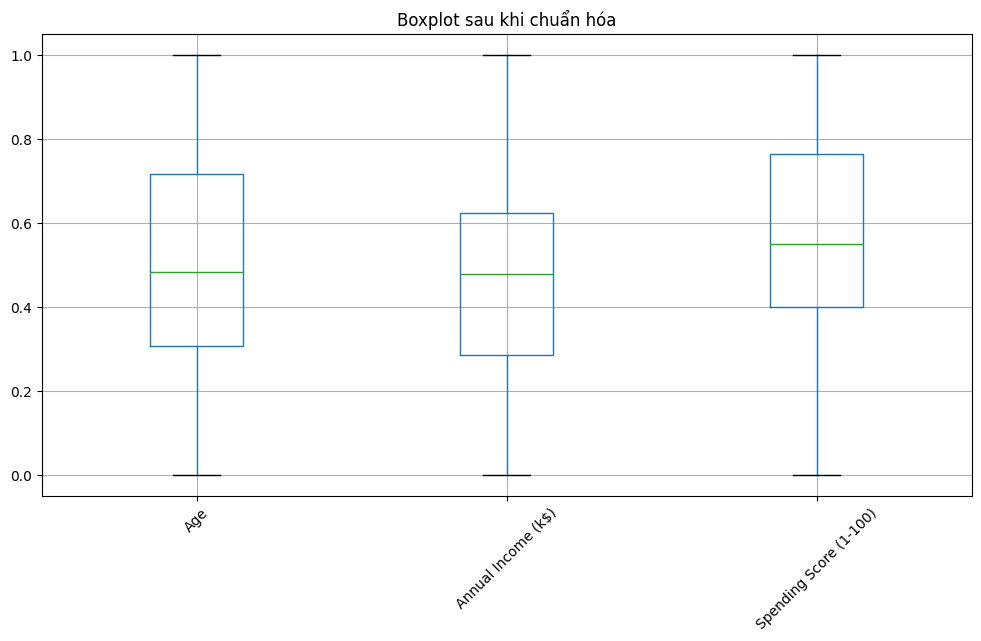

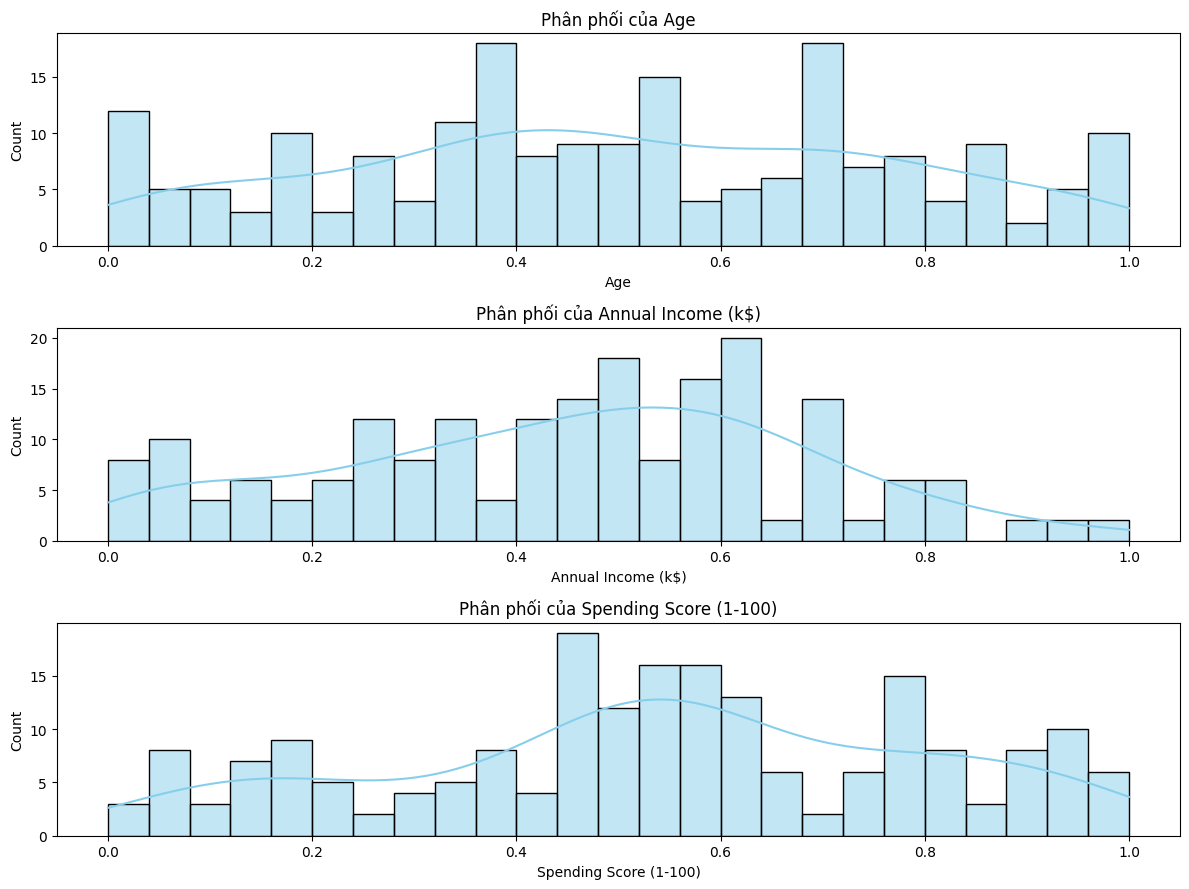


Dữ liệu đã sẵn sàng để đưa vào HDBSCAN.


,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,0.035408,0.000000,0.439701,1
1,0.101913,0.000000,0.839389,1
2,0.069337,0.012801,0.071306,0
3,0.163442,0.012801,0.802999,0
4,0.372547,0.025399,0.449795,0


In [13]:
results = []
for col in numeric_cols:
    data = df[col].dropna()
    shapiro_p = shapiro(data).pvalue
    dagostino_p = normaltest(data).pvalue
    results.append({
        'Feature': col,
        'Shapiro_p': shapiro_p,
        'DAgostino_p': dagostino_p,
        'Kết luận': 'Chuẩn' if (shapiro_p > 0.05 and dagostino_p > 0.05) else 'Không chuẩn'
    })
results_df = pd.DataFrame(results)
print("\nKết quả kiểm định phân phối chuẩn:")
display(results_df)

# Vẽ histogram + KDE
plt.figure(figsize=(12, len(numeric_cols)*3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(df[col], kde=True, bins=25, color='skyblue')
    plt.title(f"Phân phối của {col}")
plt.tight_layout()
plt.show()


print("\nThống kê mô tả dữ liệu:")
display(df[numeric_cols].describe().T)


non_normal_cols = results_df[results_df["Kết luận"] == "Không chuẩn"]["Feature"].tolist()
print(f"\nCác cột không chuẩn: {non_normal_cols}")




pt = PowerTransformer(method='yeo-johnson')
df_transformed = df.copy()
df_transformed[non_normal_cols] = pt.fit_transform(df_transformed[non_normal_cols])
print("Đã áp dụng PowerTransformer (Yeo–Johnson) cho các cột không chuẩn.")


scaler = MinMaxScaler()
df_scaled = df_transformed.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])
print("Đã chuẩn hóa toàn bộ dữ liệu.")


plt.figure(figsize=(12, 6))
df_scaled[numeric_cols].boxplot()
plt.title("Boxplot sau khi chuẩn hóa")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, len(numeric_cols)*3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(df_scaled[col], kde=True, bins=25, color='skyblue')
    plt.title(f"Phân phối của {col}")
plt.tight_layout()
plt.show()
print("\nDữ liệu đã sẵn sàng để đưa vào HDBSCAN.")
display(df_scaled.head())

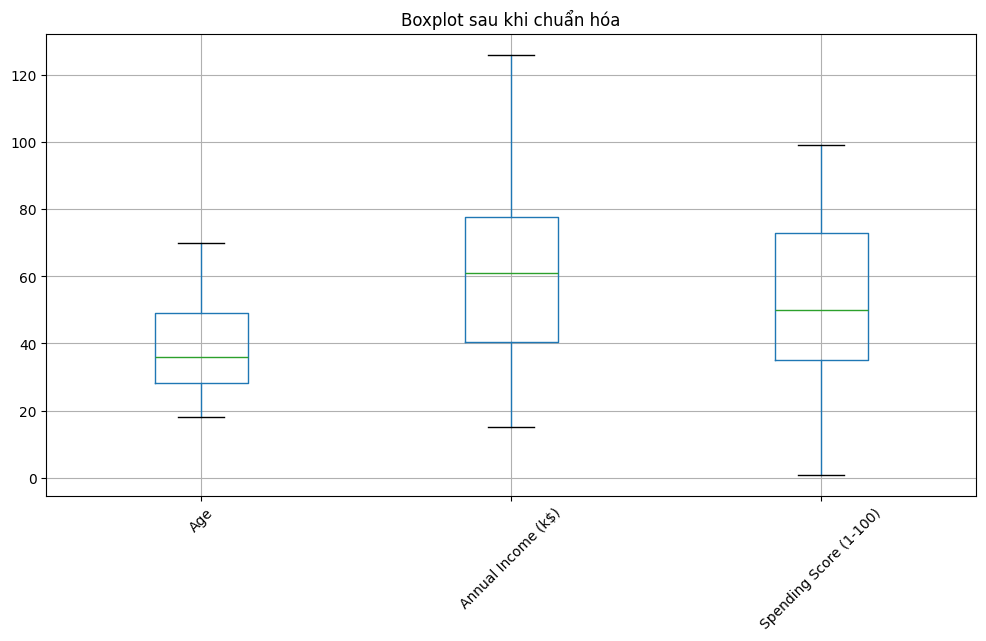

In [14]:
#boxplot sau chuẩn hóa
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Boxplot sau khi chuẩn hóa")
plt.xticks(rotation=45)
plt.show()


In [15]:
X_scaled = df_scaled.to_numpy()
param_grid = {
    "min_cluster_size": [2, 3, 5, 8, 10, 15, 20],
    "min_samples": [1, 3, 5],
    "cluster_selection_epsilon": [0, 0.05, 0.1],
    "metric": ["euclidean", "cityblock"]
}

print("\nBắt đầu tuning HDBSCAN...")
results = []

for params in [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]:
    try:
        clusterer = hdbscan.HDBSCAN(**params)
        cluster_labels = clusterer.fit_predict(X_scaled)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        if n_clusters > 1:
            dbcv = validity_index(X_scaled, cluster_labels, metric=params["metric"])
        else:
            dbcv = -1
        results.append({
            **params,
            "Clusters": n_clusters,
            "DBCV": dbcv
        })
    except Exception as e:
        print(f"Lỗi với params {params}: {e}")


if len(results) > 0:
    results_df = pd.DataFrame(results).sort_values(by="DBCV", ascending=False)
    print("\nTop 10 bộ tham số tốt nhất:")
    display(results_df.head(10))

    best_params = results_df.iloc[0].to_dict()
    print("\nTham số tốt nhất:", best_params)


clusterer_best = hdbscan.HDBSCAN(
    min_cluster_size=int(best_params["min_cluster_size"]),
    min_samples=int(best_params["min_samples"]),
    cluster_selection_epsilon=float(best_params["cluster_selection_epsilon"]),
    metric=best_params["metric"]
)
labels = clusterer_best.fit_predict(X_scaled)
df["Cluster"] = labels


Bắt đầu tuning HDBSCAN...

Top 10 bộ tham số tốt nhất:


,min_cluster_size,min_samples,cluster_selection_epsilon,metric,Clusters,DBCV
40,5,1,0.10,euclidean,2,0.623524
98,15,3,0.05,euclidean,2,0.623524
32,3,5,0.05,euclidean,2,0.623524
104,15,5,0.05,euclidean,2,0.623524
34,3,5,0.10,euclidean,2,0.623524
68,8,5,0.05,euclidean,2,0.623524
36,5,1,0.00,euclidean,2,0.623524
102,15,5,0.00,euclidean,2,0.623524
38,5,1,0.05,euclidean,2,0.623524
80,10,3,0.05,euclidean,2,0.623524



Tham số tốt nhất: {'min_cluster_size': 5, 'min_samples': 1, 'cluster_selection_epsilon': 0.1, 'metric': 'euclidean', 'Clusters': 2, 'DBCV': 0.6235244017335578}


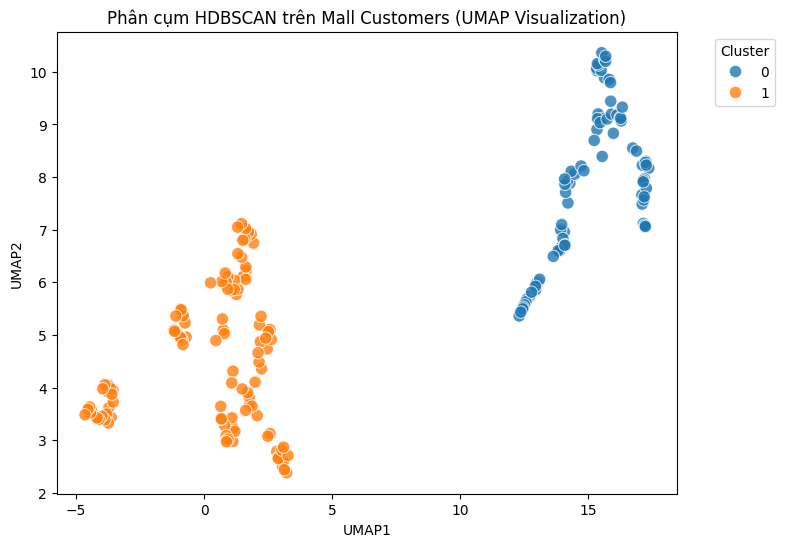

In [16]:
# Giảm chiều để trực quan hóa
reducer = umap.UMAP(random_state=87)
embedding = reducer.fit_transform(X_scaled)
df["UMAP1"], df["UMAP2"] = embedding[:, 0], embedding[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="UMAP1", y="UMAP2",
    hue="Cluster",
    palette="tab10",
    s=80, alpha=0.8
)
plt.title("Phân cụm HDBSCAN trên Mall Customers (UMAP Visualization)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()
